# 0.Setup

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 4.0 MB 9.9 MB/s 
     |████████████████████████████████| 10.6 MB 7.3 MB/s 


In [2]:
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import manifold
from time import process_time
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import altair as alt

__ONLY USE THIS CELL WHEN ON GOOGLE COLAB__

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## __IMPORT DATASET__

In [92]:
# Load ratings/movies dataset from 100K MovieLens
dataset = ['100k', '1m', '20m', '25m']

def load_dataset(dataset='100k'):
  ratings = tfds.load(f'movielens/{dataset}-ratings', split='train')
  movies = tfds.load(f'movielens/{dataset}-movies', split='train')

  return ratings, movies

ratings, movies = load_dataset(dataset[0])

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    'user_occupation': x['user_occupation_text']
})
full_movies = movies.map(lambda x: {'movie_title': x['movie_title'],
                                  'genres': x['movie_genres']})

movies = movies.map(lambda x: x["movie_title"])


In [18]:
ratings_df = tfds.as_dataframe(ratings)
movies_df = tfds.as_dataframe(movies)
# movies_df.rename(columns={' ': 'movie_title'}, inplace=True)

In [19]:
ratings_df.info()
movies_df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bucketized_user_age    100000 non-null  float64
 1   movie_genres           100000 non-null  object 
 2   movie_id               100000 non-null  object 
 3   movie_title            100000 non-null  object 
 4   raw_user_age           100000 non-null  float64
 5   timestamp              100000 non-null  int64  
 6   user_gender            100000 non-null  bool   
 7   user_id                100000 non-null  object 
 8   user_occupation_label  100000 non-null  int64  
 9   user_occupation_text   100000 non-null  object 
 10  user_rating            100000 non-null  float64
 11  user_zip_code          100000 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 8.5+ MB
<class 'tensorflow_datasets.core.as_dataframe.Style

##__SPLITTING THE DATASET__

In [115]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)

size = [100000, 1000000]
shuffled = ratings.shuffle(size[0], seed=42, reshuffle_each_iteration=False)

train_set = shuffled.take(int(0.8*size[0]))
val_set = shuffled.skip(int(0.8*size[0])).take(int(0.2*size[0]))
test_set = shuffled.skip(int(0.6*size[0])).take(int(0.2*size[0]))

movie_titles = movies.batch(int(0.1*size[0]))
user_ids = ratings.batch(size[0]).map(lambda x: x["user_id"])
user_occupation_text = ratings.batch(size[0]).map(lambda x: x['user_occupation'])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_user_occ = np.unique(np.concatenate(list(user_occupation_text)))

In [19]:
unique_movie_titles.shape

(1664,)

# 1.Building Model

In [138]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    super().__init__()

    embedding_dimension = 25

    # Embedding layers of User and Movie
    # Compute embeddings for users.
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension, embeddings_regularizer='l2', name='user_embedding')
    ])
    
    self.user_occ_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension, embeddings_regularizer='l2', name='user_occ_embedding')
    ])

    # Compute embeddings for movies.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension, embeddings_regularizer='l2', name='movie_embedding')
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(128, activation="relu"),
      # tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(128, activation="relu"),
      # tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(128, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1, activation='sigmoid')
  ], name='ANN_part')

    # Rating task
    # Loss --> Mean Squared Error (MSE)
    # Metric --> Root Mean Squared Error (RMSE)
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    # Retrieval task
    # Metric --> Factorized Top K
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(300).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    high = 5.0
    low = 0.5
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features['user_id'])
    # print('done user embedding')
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features['movie_title'])
    user_occ_embeddings = self.user_occ_model(features['user_occupation'])
    # print('done movie embedding')

    return (
        user_embeddings,
        movie_embeddings,
        user_occ_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        # self.ratings(tf.concat([user_embeddings, movie_embeddings], axis=1)),
        self.ratings(tf.concat([user_embeddings, user_occ_embeddings, movie_embeddings], axis=1))*(high-low) + low,
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, user_occ_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss

            + self.retrieval_weight * retrieval_loss)

In [110]:
# tf.keras.utils.plot_model(model, "movielens_model.png")
model.summary()

Model: "movielens_model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_22 (Sequential)   (None, 35)                33040     
_________________________________________________________________
sequential_23 (Sequential)   (None, 35)                58275     
_________________________________________________________________
ANN_part (Sequential)        (None, 1)                 63233     
_________________________________________________________________
ranking_11 (Ranking)         multiple                  0         
_________________________________________________________________
retrieval_9 (Retrieval)      multiple                  1         
Total params: 154,549
Trainable params: 154,548
Non-trainable params: 1
_________________________________________________________________


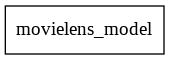

In [22]:
tf.keras.utils.plot_model(model, "movie_recommendation.png", expand_nested=True, layer_range=['sequential', 'retrieval'])

## Compile and preparing the pipeline

In [139]:
# model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model = MovielensModel(rating_weight=0.8, retrieval_weight=0.8)
# model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.09))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_total_loss', factor=0.2, patience=5, min_lr=0.001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', patience=10)

cached_train = train_set.shuffle(size[0]).batch(10000).cache()
cached_test = test_set.batch(5000).cache()
cached_val = val_set.batch(5000).cache()

## Train the model

In [140]:
history = model.fit(cached_train, 
                    validation_data=cached_val, 
                    epochs=100, 
                    callbacks = [reduce_lr])
# model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/100
8/8 [==============================] - 9s 891ms/step - root_mean_squared_error: 1.2837 - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0309 - factorized_top_k/top_100_categorical_accuracy: 0.0611 - loss: 73684.2422 - regularization_loss: 0.6914 - total_loss: 73684.9332 - val_root_mean_squared_error: 1.1607 - val_factorized_top_k/top_1_categorical_accuracy: 5.5000e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0038 - val_factorized_top_k/top_10_categorical_accuracy: 0.0074 - val_factorized_top_k/top_50_categorical_accuracy: 0.0306 - val_factorized_top_k/top_100_categorical_accuracy: 0.0615 - val_loss: 34069.6875 - val_regularization_loss: 0.6486 - val_total_loss: 34070.3359
Epoch 2/100
8/8 [==============================] - 5s 629ms/step - root_mean_squared_error: 1.1453 - factorized_top_k/top_1_cat

## Saving model

In [141]:
import datetime, os
curr_date = str(datetime.datetime.now().year) + '_' + str(datetime.datetime.now().month) + '_' + str(datetime.datetime.now().day)

# THIS PATH IS USE FOR MY GOOGLE DRIVE FOLDER
# model_folder = '/content/gdrive/MyDrive/Colab_Notebooks/XProject/model'

# THIS PATH IS USE ON MY LOCAL FOLDER
# model_folder = '/models'

# Choose your own folder path
# model_folder = # YOUR CODE HERE

model_path = os.path.join(model_folder, f'multitask_model_{curr_date}_04')
# model_path = os.path.join(model_folder, f'multitask_model_2021_10_18_batchnorm_02')

# Print out the model_path to double check
print(model_path)

/content/gdrive/MyDrive/Colab_Notebooks/XProject/model/multitask_model_2021_10_21_04


In [142]:
model.save_weights(model_path)

## Load model

In [144]:
# Assign the model
# loaded_model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
loaded_model = MovielensModel(rating_weight=0.8, retrieval_weight=0.8)

# Compile the model
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Restore the weights
loaded_model.load_weights(model_path)

In [145]:
import time
start_time = time.time()
loaded_metrics = loaded_model.evaluate(cached_test, return_dict=True)
end_time = time.time()

print(end_time - start_time)
print(f"Retrieval top-100 accuracy: {loaded_metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Retrieval top-50 accuracy: {loaded_metrics['factorized_top_k/top_50_categorical_accuracy']:.3f}.")
print(f"Retrieval top-10 accuracy: {loaded_metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {loaded_metrics['root_mean_squared_error']:.3f}.")

4/4 [==============================] - 2s 278ms/step - root_mean_squared_error: 0.8225 - factorized_top_k/top_1_categorical_accuracy: 0.0045 - factorized_top_k/top_5_categorical_accuracy: 0.0302 - factorized_top_k/top_10_categorical_accuracy: 0.0562 - factorized_top_k/top_50_categorical_accuracy: 0.2097 - factorized_top_k/top_100_categorical_accuracy: 0.3394 - loss: 31396.3230 - regularization_loss: 96.6263 - total_loss: 31492.9500
1.7731571197509766
Retrieval top-100 accuracy: 0.339.
Retrieval top-50 accuracy: 0.210.
Retrieval top-10 accuracy: 0.056.
Ranking RMSE: 0.823.


# 2.Plotting the model learning curve

In [30]:
def plotting_history(rmse, val_rmse, loss, val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(rmse, label='Training RMSE')
  plt.plot(val_rmse, label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.ylabel('RMSE')
  # plt.ylim([min(plt.ylim()),1])
  # plt.ylim([0,1.0])
  plt.title('Training and Validation RMSE')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Total loss')
  # plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show() 

def plotting_metrics(top10, top50, top100, val_top10, val_top50, val_top100):
  plt.figure(figsize=(10, 10))
  plt.subplot(3, 1, 1)
  plt.plot(top10, label='Training Top10 Accuracy')
  plt.plot(val_top10, label='Validation top10 Accuracy')
  plt.legend(loc='upper right')
  plt.ylabel('Accuracy(%)')
  plt.title('Training and Validation Top10 Accuracy')

  plt.subplot(3, 1, 2)
  plt.plot(top50, label='Training Top50 Accuracy')
  plt.plot(val_top50, label='Validation Top50 Accuracy')
  plt.legend(loc='upper right')
  plt.ylabel('Accuracy(%)')
  plt.title('Training and Validation Top50 Accuracy')

  plt.subplot(3, 1, 3)
  plt.plot(top100, label='Training Top100 Accuracy')
  plt.plot(val_top100, label='Validation Top100 Accuracy')
  plt.legend(loc='upper right')
  plt.ylabel('Accuracy(%)')
  plt.title('Training and Validation Top100 Accuracy')
  plt.xlabel('epoch')
  plt.show() 

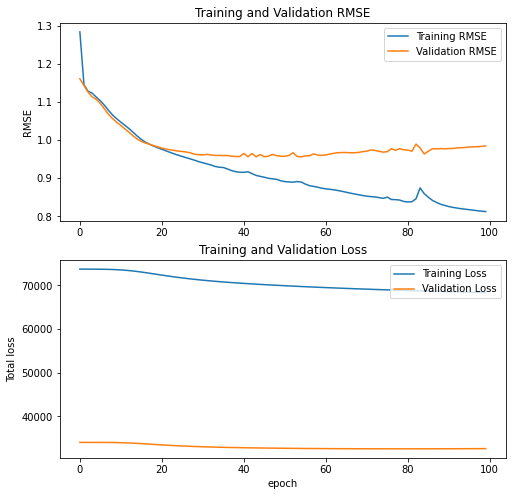

In [146]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['total_loss']
val_loss = history.history['val_total_loss']

plotting_history(rmse, val_rmse, loss, val_loss)

In [15]:
history.history.keys()

dict_keys(['root_mean_squared_error', 'factorized_top_k/top_1_categorical_accuracy', 'factorized_top_k/top_5_categorical_accuracy', 'factorized_top_k/top_10_categorical_accuracy', 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy', 'loss', 'regularization_loss', 'total_loss', 'val_root_mean_squared_error', 'val_factorized_top_k/top_1_categorical_accuracy', 'val_factorized_top_k/top_5_categorical_accuracy', 'val_factorized_top_k/top_10_categorical_accuracy', 'val_factorized_top_k/top_50_categorical_accuracy', 'val_factorized_top_k/top_100_categorical_accuracy', 'val_loss', 'val_regularization_loss', 'val_total_loss', 'lr'])

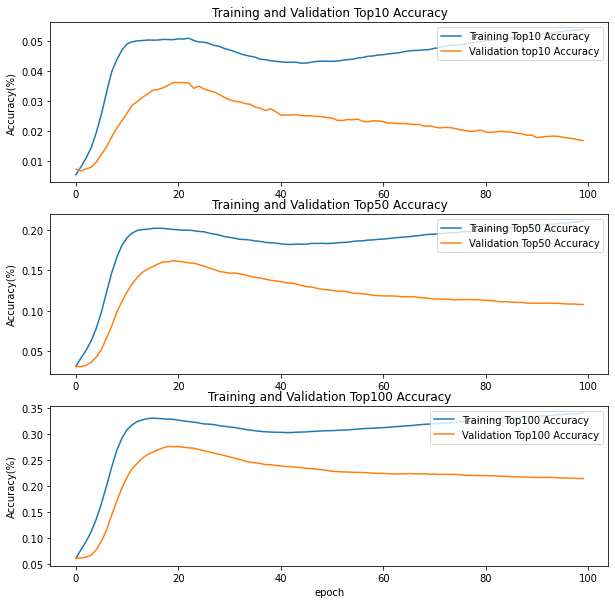

In [147]:
top10 = history.history['factorized_top_k/top_10_categorical_accuracy']
top50 = history.history['factorized_top_k/top_50_categorical_accuracy']
top100 = history.history['factorized_top_k/top_100_categorical_accuracy']

val_top10 = history.history['val_factorized_top_k/top_10_categorical_accuracy']
val_top50 = history.history['val_factorized_top_k/top_50_categorical_accuracy']
val_top100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

plotting_metrics(top10, top50, top100, val_top10, val_top50, val_top100)

# 3.Plotting the Embedding space

In [34]:
def tsne_movie_embeddings(model):
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  x = model.movie_model.layers[-1](tf.constant(list(range(len(unique_movie_titles)+1)))).numpy()
  print('Running t-SNE...')
  V_proj = tsne.fit_transform(x)
  return V_proj

In [148]:
V_proj = tsne_movie_embeddings(model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1665 samples in 0.000s...
[t-SNE] Computed neighbors for 1665 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1665
[t-SNE] Computed conditional probabilities for sample 1665 / 1665
[t-SNE] Mean sigma: 0.224033
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.266373
[t-SNE] KL divergence after 400 iterations: 1.168516


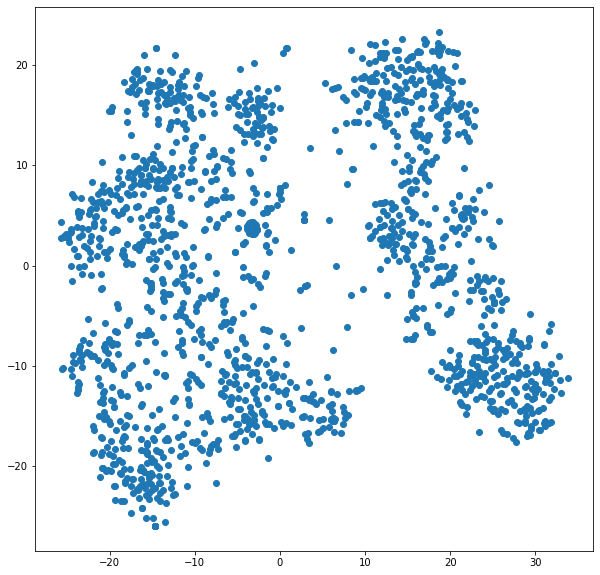

In [149]:
idx = list(range(50,60,1))

X = V_proj[:,0]
Y = V_proj[:,1]

# X = V_proj[50:60,0]
# Y = V_proj[50:60,1]
plt.figure(figsize=(10,10))
plt.scatter(X, Y)
# for i, x, y in zip(movies_df['movie_title'][idx], X, Y):
    # plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# 4.Model serving

In [150]:
scann_index = tfrs.layers.factorized_top_k.ScaNN(loaded_model.user_model, k=50)
scann_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(128), movies.batch(128).map(loaded_model.movie_model)))
)
# Create a model that takes in raw query features, and
bf_index = tfrs.layers.factorized_top_k.BruteForce(loaded_model.user_model, k=50)
# recommends movies out of the entire movies dataset.
bf_index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(128), movies.batch(128).map(loaded_model.movie_model)))
)

In [153]:
# Get recommendations.
user = str(len(unique_user_ids)-100)
scores, titles = scann_index(tf.constant([user]))
scores = scores
bf_scores, bf_titles = bf_index(tf.constant([user]))
bf_scores = bf_scores
print(f"ScaNN Recommendations for user {user}: {titles[0, :50]}")
print(f'ScaNN Rating scores of user {user}: {scores[0, :50]}')
print('='*100)
print(f'Bruce force Recommendations for user {user}: {bf_titles[0, :50]}')
print(f'Bruce force Rating scores of user {user}: {bf_scores[0,:50]}')


ScaNN Recommendations for user 843: [b'Audrey Rose (1977)' b'Blob, The (1958)' b'Cat People (1982)'
 b'Burnt Offerings (1976)' b'Fog, The (1980)'
 b'Amityville II: The Possession (1982)' b'Lord of Illusions (1995)'
 b'Village of the Damned (1995)' b"Stephen King's The Langoliers (1995)"
 b'Amityville Horror, The (1979)'
 b'American Werewolf in London, An (1981)' b'Bride of Frankenstein (1935)'
 b'Hellraiser: Bloodline (1996)' b"Wes Craven's New Nightmare (1994)"
 b'20,000 Leagues Under the Sea (1954)' b'Body Snatchers (1993)'
 b'Body Snatchers (1993)' b"Mary Shelley's Frankenstein (1994)"
 b'Body Snatcher, The (1945)' b'Howling, The (1981)'
 b'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'
 b'Omen, The (1976)' b'Day the Earth Stood Still, The (1951)'
 b'Carrie (1976)' b'Fantasia (1940)' b'Black Beauty (1994)'
 b'Nightmare on Elm Street, A (1984)' b'Night of the Living Dead (1968)'
 b'Believers, The (1987)' b'Faster Pussycat! Kill! Kill! (1965)'
 b'Mark of Zorro, The (1940)' 

In [154]:
# bf_titles.numpy().reshape(10)
bf_movies_list = pd.DataFrame(bf_titles.numpy().reshape(50), columns=['Movies List'])
bf_movies_list['Predicted Ratings'] = pd.Series(bf_scores.numpy().reshape(50))
scann_movies_list = pd.DataFrame(titles.numpy().reshape(50), columns=['Movies List'])
scann_movies_list['Predicted Ratings'] = pd.Series(scores.numpy().reshape(50))

def clean(row):
  return str(row).split('\'')[1]

bf_movies_list['Movies List'] = bf_movies_list['Movies List'].apply(clean)

scann_movies_list['Movies List'] = scann_movies_list['Movies List'].apply(clean)


print(f'Recommendation for user {user}')
print('Using brute force search')
display(bf_movies_list)
print('='*40)
print('Using ScaNN search')
display(scann_movies_list)

Recommendation for user 843
Using brute force search


,Movies List,Predicted Ratings
0,Audrey Rose (1977),3.586499
1,"Blob, The (1958)",3.553118
2,Cat People (1982),3.413805
3,Burnt Offerings (1976),3.272260
4,Forbidden Planet (1956),3.253865
5,"Fog, The (1980)",3.153710
6,"s The Langoliers (1995)""",3.075823
7,Bride of Frankenstein (1935),3.062469
8,Amityville II: The Possession (1982),3.037778
9,Village of the Damned (1995),3.010684


Using ScaNN search


,Movies List,Predicted Ratings
0,Audrey Rose (1977),3.716183
1,"Blob, The (1958)",3.320994
2,Cat People (1982),3.167444
3,Burnt Offerings (1976),3.135058
4,"Fog, The (1980)",3.039823
5,Amityville II: The Possession (1982),2.980867
6,Lord of Illusions (1995),2.940052
7,Village of the Damned (1995),2.917377
8,"s The Langoliers (1995)""",2.881097
9,"Amityville Horror, The (1979)",2.840281


In [82]:
ratings_df['user_id'] = ratings_df['user_id'].apply(clean)
ratings_df['movie_title'] = ratings_df['movie_title'].apply(clean) 

In [155]:
current_user = ratings_df[ratings_df['user_id']==user]
# current_user.head()
current_user.dropna(inplace=True)
current_user.sort_values('user_rating', ascending=False)[:50]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
7260,35.0,"[0, 1, 15, 18]",b'271',Starship Troopers (1997),35.0,879442947,True,843,10,b'librarian',5.0,b'44212'
36820,35.0,"[7, 15]",b'7',Twelve Monkeys (1995),35.0,879443297,True,843,10,b'librarian',5.0,b'44212'
63934,35.0,"[0, 10, 15, 16]",b'183',Alien (1979),35.0,879443800,True,843,10,b'librarian',5.0,b'44212'
16932,35.0,"[7, 18]",b'690',Seven Years in Tibet (1997),35.0,879442947,True,843,10,b'librarian',5.0,b'44212'
90545,35.0,"[9, 15]",b'89',Blade Runner (1982),35.0,879444670,True,843,10,b'librarian',5.0,b'44212'
41357,35.0,[10],b'675',"Nosferatu (Nosferatu, eine Symphonie des Graue...",35.0,879443174,True,843,10,b'librarian',5.0,b'44212'
89048,35.0,"[7, 13, 15, 16]",b'135',2001: A Space Odyssey (1968),35.0,879449177,True,843,10,b'librarian',5.0,b'44212'
75068,35.0,[15],b'179',"Clockwork Orange, A (1971)",35.0,879446774,True,843,10,b'librarian',4.0,b'44212'
51594,35.0,"[10, 16]",b'288',Scream (1996),35.0,879443544,True,843,10,b'librarian',4.0,b'44212'
13691,35.0,"[1, 3, 8, 15]",b'141',"20,000 Leagues Under the Sea (1954)",35.0,879447327,True,843,10,b'librarian',4.0,b'44212'


In [179]:
user_ratings = ratings_df.pivot_table(index='user_id', columns='movie_title', values='user_rating', aggfunc='mean')
user_ratings.sort_values('user_id', ascending=True)
user_ratings.fillna(0.0, inplace=True)